**SBT**

In [ ]:
import pandas as pd
import numpy as np
#data = pd.read_csv("/content/sample.csv")
data_all= pd.read_excel("/content/four.xlsx")
data_all.head()
#stock_df = pd.DataFrame(data)
data = data_all[data_all['code'] == 'SBT']
data.head()

,date,code,basicPrice,open,close,high,low
2,2023-09-08,SBT,16.35,16.50,16.65,16.75,16.35
9,2023-09-07,SBT,16.55,16.55,16.35,16.65,16.20
13,2023-09-06,SBT,16.45,16.70,16.55,16.80,16.50
16,2023-09-05,SBT,16.20,16.40,16.45,16.75,16.30
23,2023-08-31,SBT,16.10,16.20,16.20,16.25,15.95


In [ ]:
# Unique values for 'code' column
unique_codes = data['code'].unique()

# Date range in the dataset
min_date = data['date'].min()
max_date = data['date'].max()

unique_codes, min_date, max_date

# Descriptive Statistics for Numerical Fields
numerical_stats = data.describe()
numerical_stats

,basicPrice,open,close,high,low
count,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000
mean,18.644599,18.642394,18.681934,18.911533,18.360606
std,6.001690,5.920192,5.952877,6.021709,5.819057
min,0.000000,9.910000,9.900000,10.300000,9.700000
25%,14.300000,14.300000,14.300000,14.500000,14.050000
50%,17.550000,17.500000,17.575000,17.775000,17.200000
75%,21.700000,21.700000,21.700000,22.062500,21.350000
max,41.650000,41.450000,41.650000,42.050000,41.050000


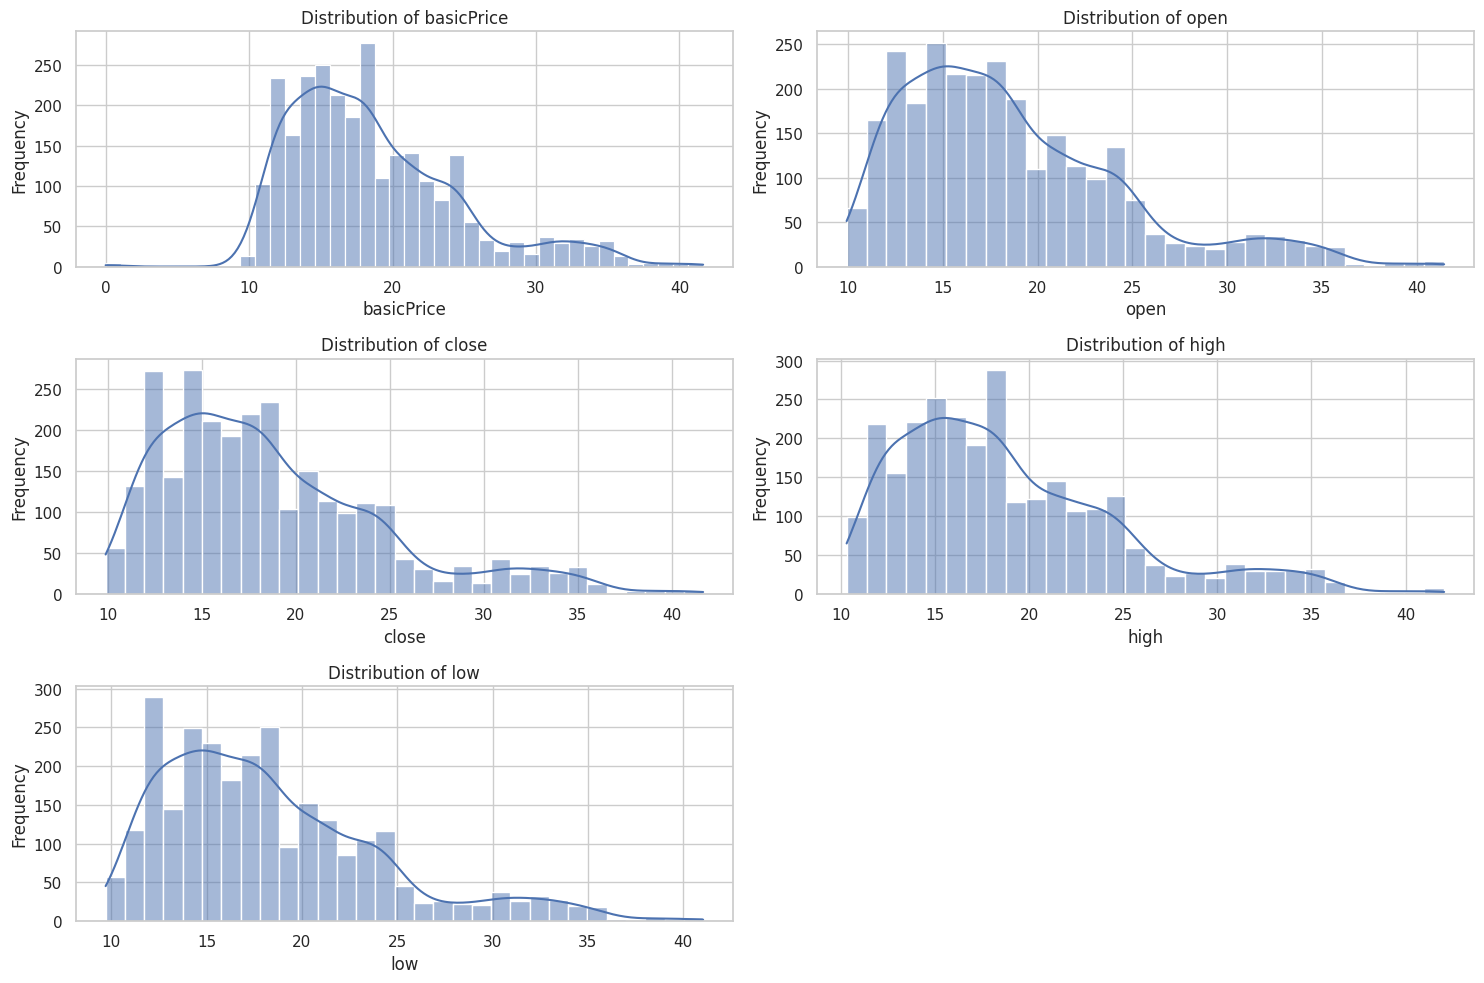

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plotting distributions of numerical columns
for i, column in enumerate(['basicPrice', 'open','close', 'high', 'low']):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

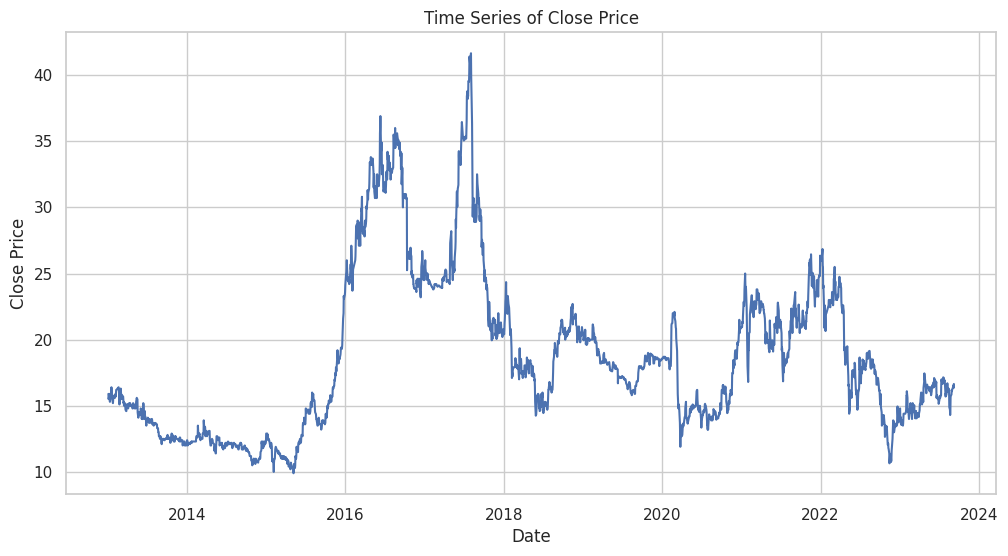

In [ ]:
# Converting 'date' from string to datetime for plotting
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Plotting time series for 'close' price
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='close', data=data)
plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

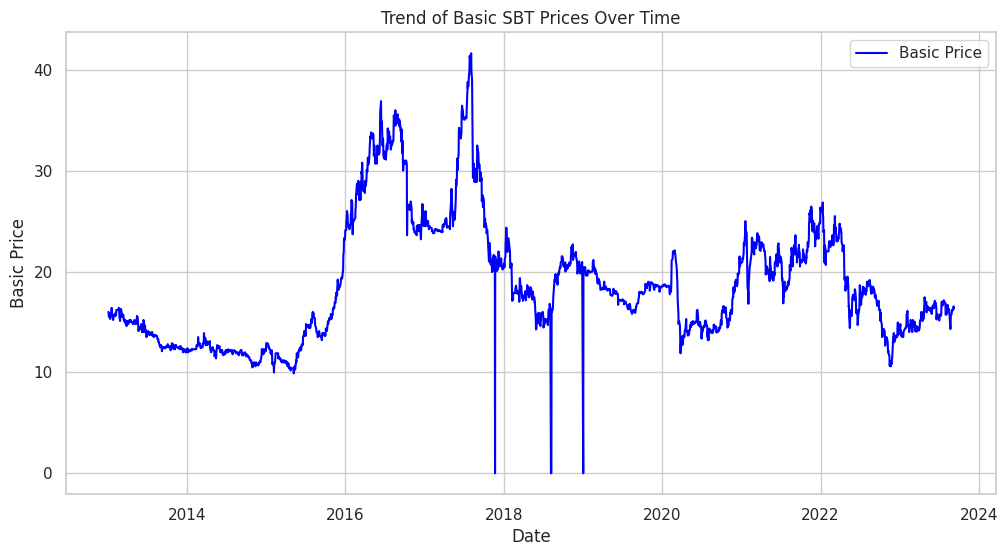

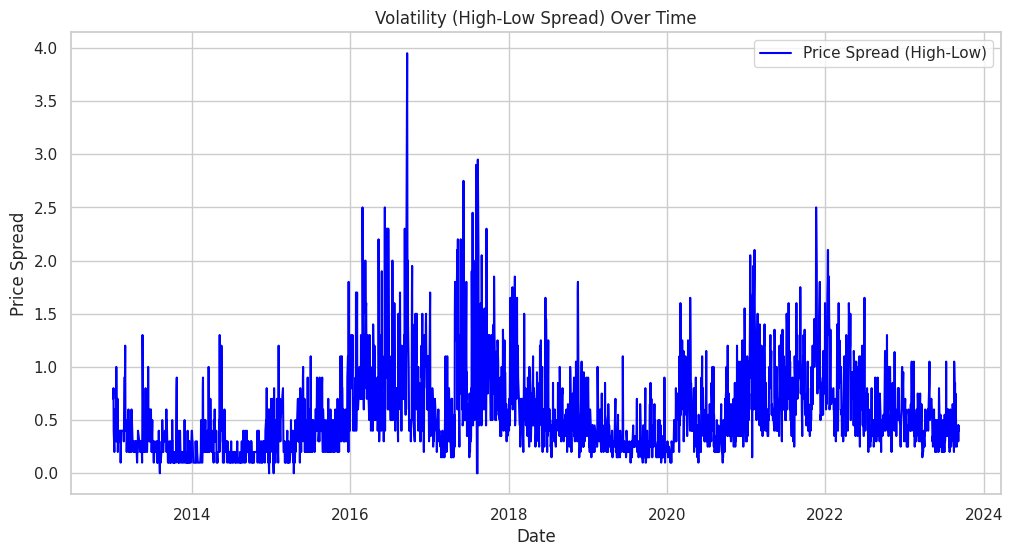

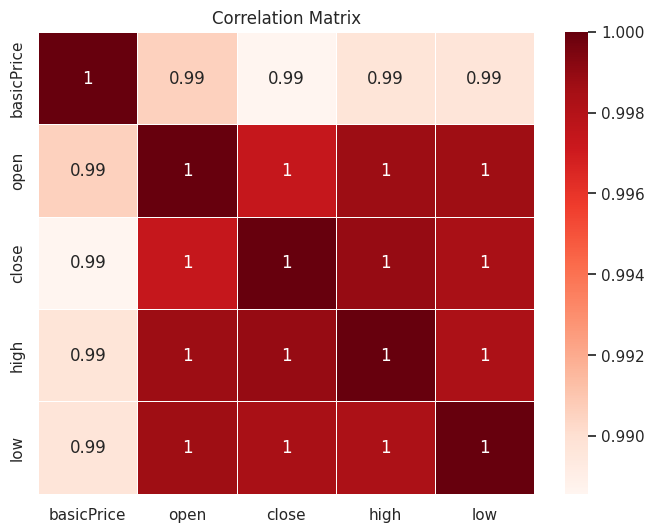

In [ ]:
sns.set(style="whitegrid")

# Trend analysis: Plotting the basic price over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['basicPrice'], label='Basic Price', color='blue')
plt.title('Trend of Basic SBT Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Basic Price')
plt.legend()
plt.show()

# Volatility analysis: High-Low Price Spread
data['price_spread'] = data['high'] - data['low']
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price_spread'], label='Price Spread (High-Low)', color='blue')
plt.title('Volatility (High-Low Spread) Over Time')
plt.xlabel('Date')
plt.ylabel('Price Spread')
plt.legend()
plt.show()

# Correlation
correlation_matrix = data[['basicPrice', 'open', 'close', 'high', 'low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Applying the test on the 'close' column
adf_test_result = test_stationarity(data['close'])
adf_test_result

Results of Dickey-Fuller Test:


Test Statistic                   -2.228593
p-value                           0.196032
#Lags Used                        1.000000
Number of Observations Used    2738.000000
Critical Value (1%)              -3.432741
Critical Value (5%)              -2.862596
Critical Value (10%)             -2.567332
dtype: float64

Since data is stationary, we need to perform first-order differencing

In [ ]:
adf_test_result1 = test_stationarity(np.diff(data['close']))
adf_test_result1

Results of Dickey-Fuller Test:


Test Statistic                  -48.889156
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2738.000000
Critical Value (1%)              -3.432741
Critical Value (5%)              -2.862596
Critical Value (10%)             -2.567332
dtype: float64

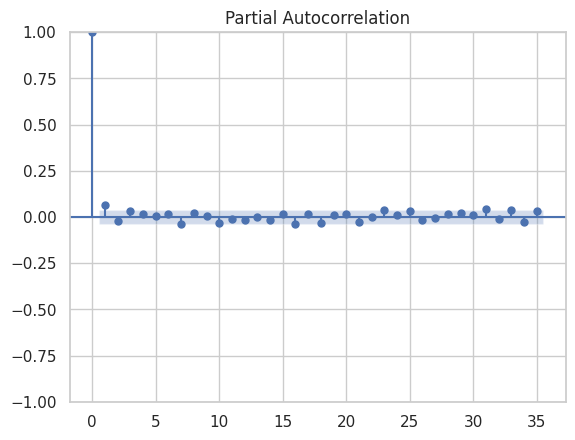

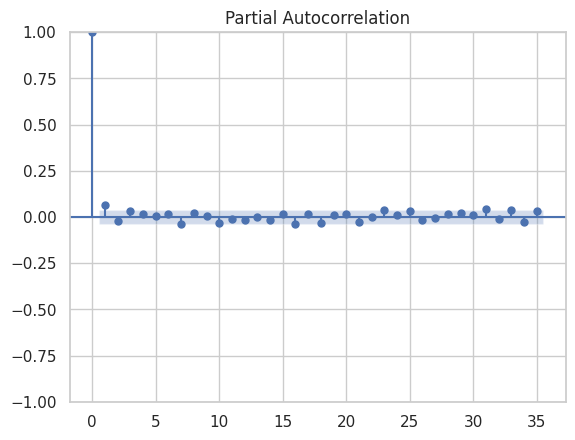

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.diff(data['close']))

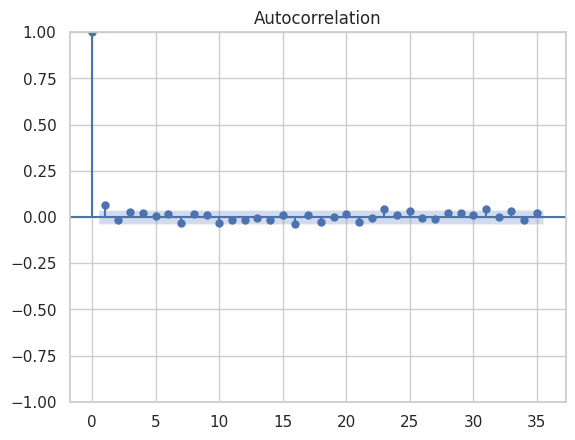

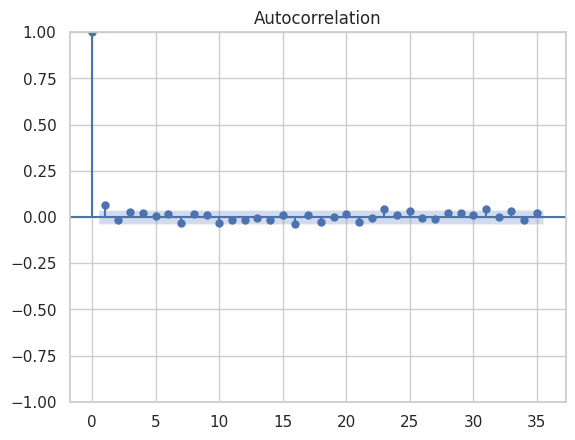

In [ ]:
plot_acf(np.diff(data['close']))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import itertools
import warnings

# Function to find the best ARIMA parameters
def find_best_arima(series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print('ARIMA({}, {}, {}) AIC={}'.format(p, d, q, aic))
        except:
            continue
    return best_cfg

# Define the p, d, q ranges to test
p_range = range(0, 3)
d_range = range(1, 2)
q_range = range(0, 3)

# Ignoring warning messages to keep the output clean
warnings.filterwarnings("ignore")

# Find the best ARIMA parameters
best_arima_params = find_best_arima(data['close'], p_range, d_range, q_range)
best_arima_params

ARIMA(0, 1, 0) AIC=3628.9877816010744
ARIMA(0, 1, 1) AIC=3617.9203223501063
ARIMA(0, 1, 2) AIC=3618.79879311905
ARIMA(1, 1, 0) AIC=3618.4729293037
ARIMA(1, 1, 1) AIC=3618.273695212933
ARIMA(1, 1, 2) AIC=3620.2726241881437
ARIMA(2, 1, 0) AIC=3619.214893713892
ARIMA(2, 1, 1) AIC=3620.2724185805237
ARIMA(2, 1, 2) AIC=3621.4221330622013


(0, 1, 1)

In [ ]:
# Fit the best ARIMA model
model = ARIMA(data['close'], order=(0, 1, 1))
model_fit = model.fit()

# Forecasting the next year (2023)
forecast_periods = 15 # Assuming daily data for 30 days
forecast = model_fit.forecast(steps=forecast_periods)

# Generating dates for the forecasted period (2023)
last_date = data['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='D')[1:]

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Basic Price': forecast.values})
forecast_df

,Date,Forecasted Basic Price
0,2023-09-09,16.672215
1,2023-09-10,16.672215
2,2023-09-11,16.672215
3,2023-09-12,16.672215
4,2023-09-13,16.672215
5,2023-09-14,16.672215
6,2023-09-15,16.672215
7,2023-09-16,16.672215
8,2023-09-17,16.672215
9,2023-09-18,16.672215


**QNS**

In [ ]:
import pandas as pd
import numpy as np
#data = pd.read_csv("/content/sample.csv")
data_all= pd.read_excel("/content/four.xlsx")
data_all.head()
#stock_df = pd.DataFrame(data)
data = data_all[data_all['code'] == 'QNS']
data.head()

,date,code,basicPrice,open,close,high,low
3,2023-09-08,QNS,50.2,50.2,50.5,50.8,50.0
6,2023-09-07,QNS,50.9,51.0,50.0,51.1,49.7
10,2023-09-06,QNS,50.8,51.0,51.0,51.4,50.5
19,2023-09-05,QNS,49.9,50.1,50.8,51.4,50.1
21,2023-08-31,QNS,49.7,49.8,50.1,50.5,49.5


In [ ]:
# Unique values for 'code' column
unique_codes = data['code'].unique()

# Date range in the dataset
min_date = data['date'].min()
max_date = data['date'].max()

unique_codes, min_date, max_date

# Descriptive Statistics for Numerical Fields
numerical_stats = data.describe()
numerical_stats

,basicPrice,open,close,high,low
count,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000
mean,46.679932,46.857355,46.873147,47.399658,46.319555
std,20.526430,20.451264,20.390010,20.640135,20.202718
min,0.000000,20.000000,20.000000,21.000000,20.000000
25%,34.200000,34.225000,34.300000,34.625000,34.000000
50%,42.200000,42.200000,42.300000,42.650000,41.850000
75%,49.900000,50.000000,49.975000,50.700000,49.100000
max,128.400000,128.800000,128.800000,128.800000,126.000000


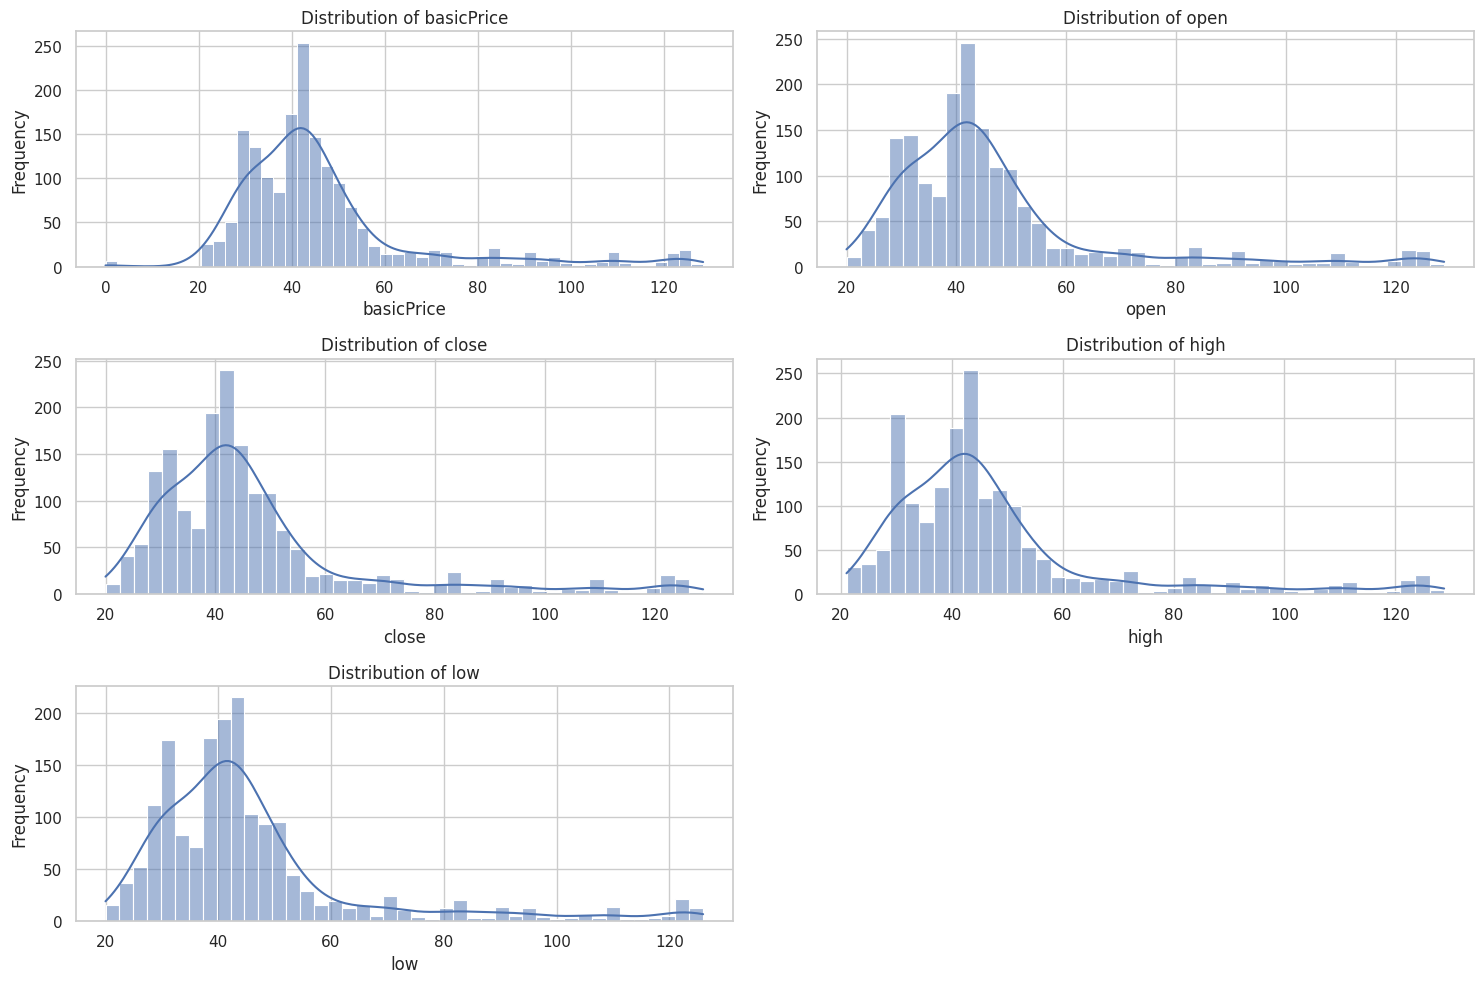

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plotting distributions of numerical columns
for i, column in enumerate(['basicPrice', 'open','close', 'high', 'low']):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

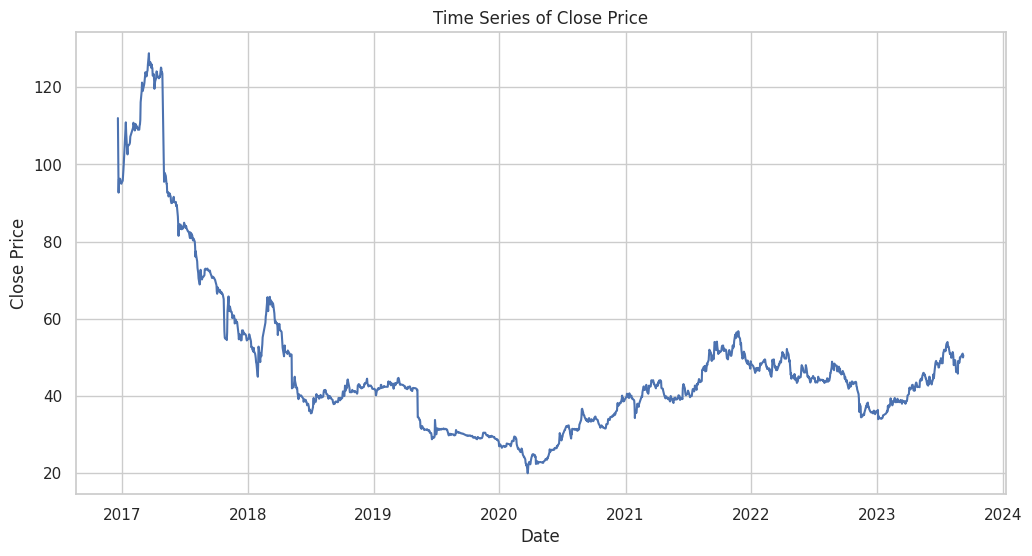

In [ ]:
# Converting 'date' from string to datetime for plotting
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Plotting time series for 'close' price
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='close', data=data)
plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

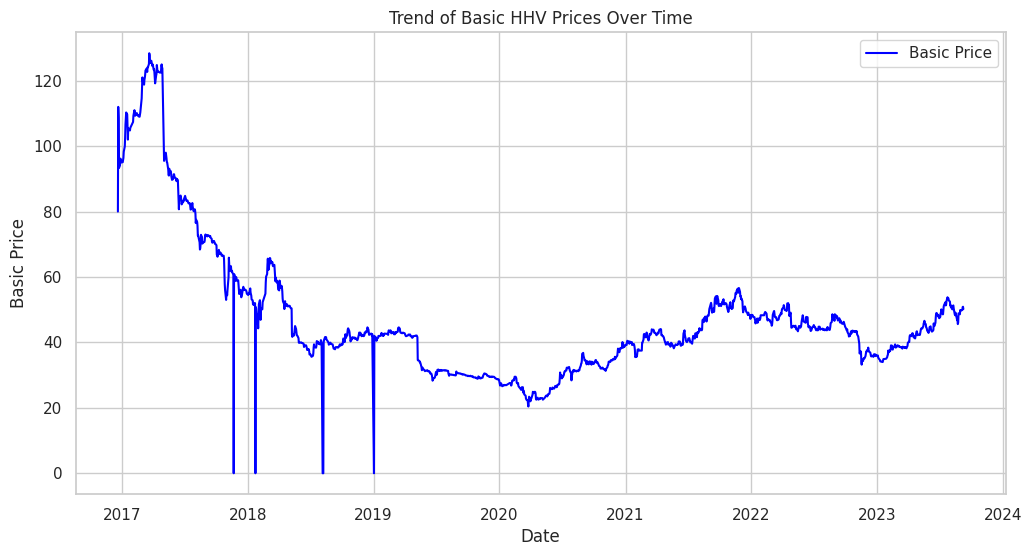

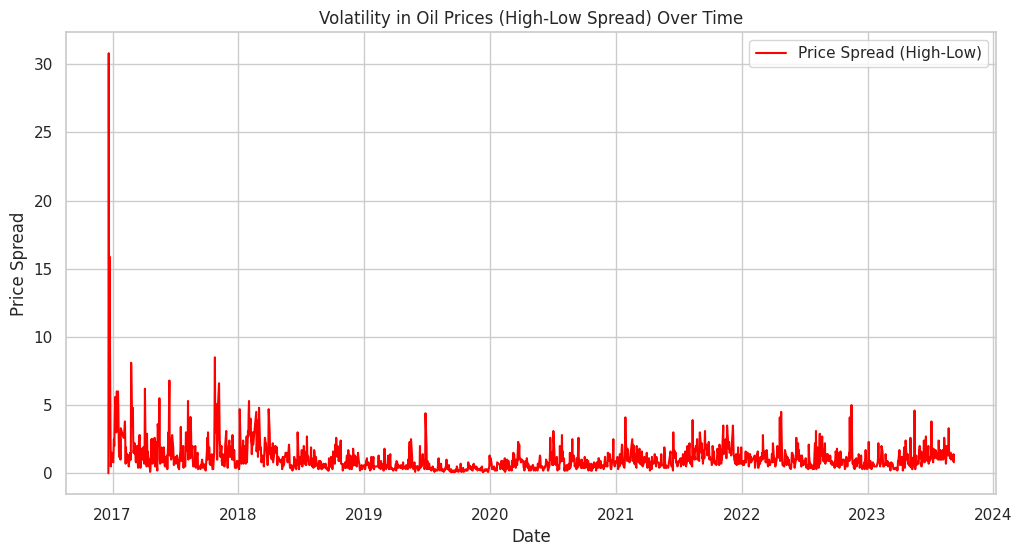

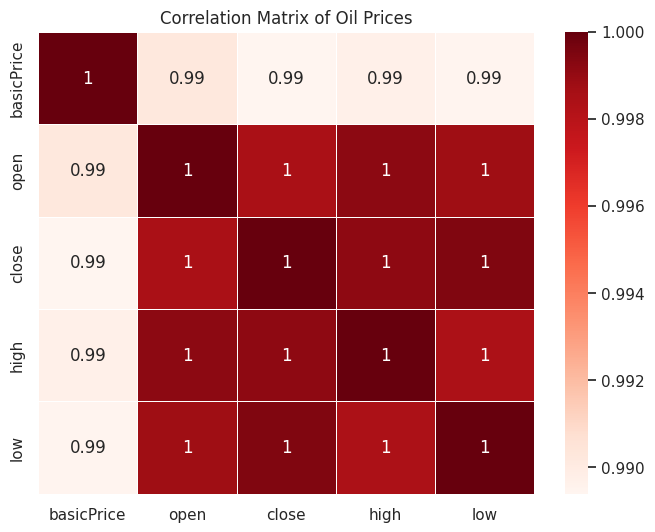

In [ ]:
sns.set(style="whitegrid")

# Trend analysis: Plotting the basic price over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['basicPrice'], label='Basic Price', color='blue')
plt.title('Trend of Basic HHV Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Basic Price')
plt.legend()
plt.show()

# Volatility analysis: High-Low Price Spread
data['price_spread'] = data['high'] - data['low']
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price_spread'], label='Price Spread (High-Low)', color='red')
plt.title('Volatility in Oil Prices (High-Low Spread) Over Time')
plt.xlabel('Date')
plt.ylabel('Price Spread')
plt.legend()
plt.show()

# Correlation
correlation_matrix = data[['basicPrice', 'open', 'close', 'high', 'low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Correlation Matrix of Oil Prices')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Applying the test on the 'basicPrice' column
adf_test_result = test_stationarity(data['basicPrice'])
adf_test_result

Results of Dickey-Fuller Test:


Test Statistic                   -2.491695
p-value                           0.117508
#Lags Used                        6.000000
Number of Observations Used    1747.000000
Critical Value (1%)              -3.434099
Critical Value (5%)              -2.863196
Critical Value (10%)             -2.567652
dtype: float64

In [ ]:
adf_test_result1 = test_stationarity(np.diff(data['basicPrice']))
adf_test_result1

Results of Dickey-Fuller Test:


Test Statistic                  -23.333991
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    1747.000000
Critical Value (1%)              -3.434099
Critical Value (5%)              -2.863196
Critical Value (10%)             -2.567652
dtype: float64

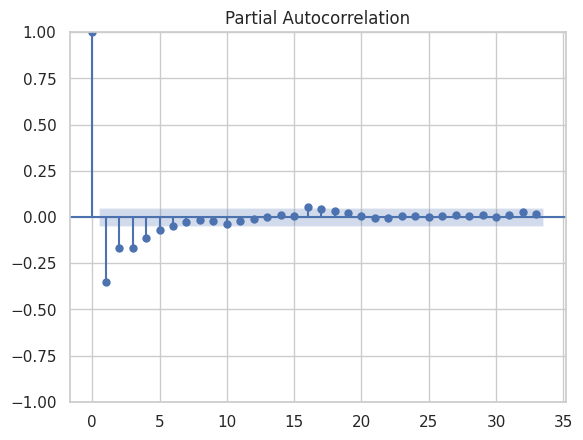

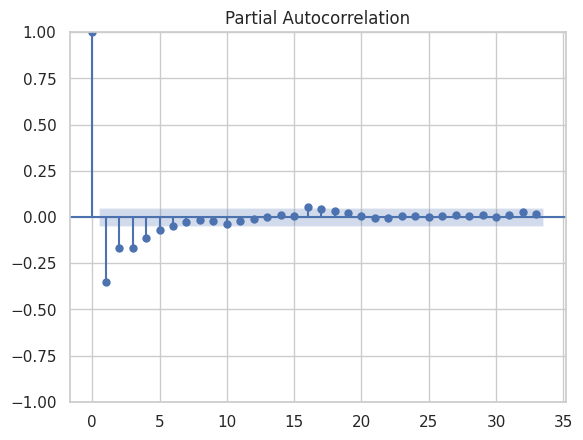

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.diff(data['basicPrice']))

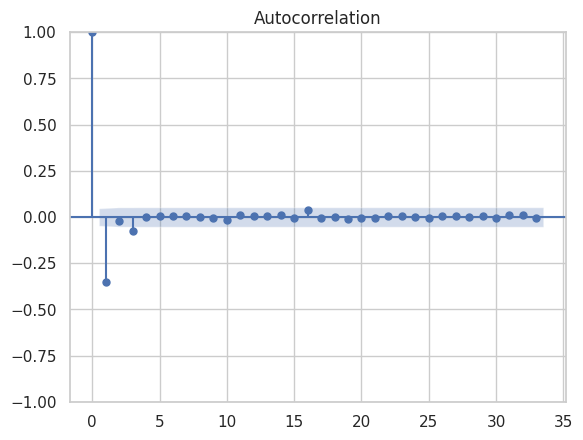

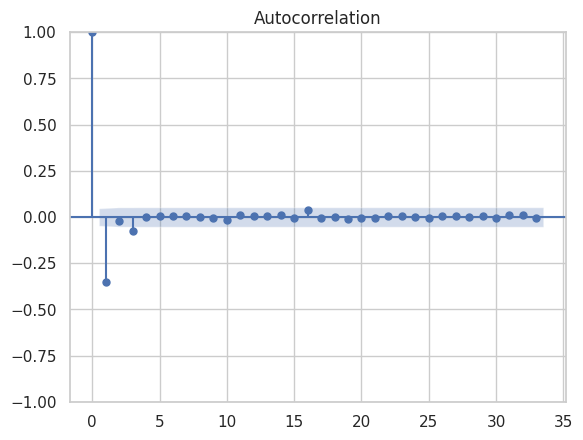

In [ ]:
plot_acf(np.diff(data['basicPrice']))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import itertools
import warnings

# Function to find the best ARIMA parameters
def find_best_arima(series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print('ARIMA({}, {}, {}) AIC={}'.format(p, d, q, aic))
        except:
            continue
    return best_cfg

# Define the p, d, q ranges to test
p_range = range(0, 5)
d_range = range(1, 2)
q_range = range(0, 4)

# Ignoring warning messages to keep the output clean
warnings.filterwarnings("ignore")

# Find the best ARIMA parameters
best_arima_params = find_best_arima(data['basicPrice'], p_range, d_range, q_range)
best_arima_params

ARIMA(0, 1, 0) AIC=9470.606716326583
ARIMA(0, 1, 1) AIC=9114.440118342522
ARIMA(0, 1, 2) AIC=9096.067934109193
ARIMA(0, 1, 3) AIC=9088.65880140349
ARIMA(1, 1, 0) AIC=9233.62774985899
ARIMA(1, 1, 1) AIC=9091.524622641007
ARIMA(1, 1, 2) AIC=9092.239877253422
ARIMA(1, 1, 3) AIC=9090.308716959345
ARIMA(2, 1, 0) AIC=9180.529484126992
ARIMA(2, 1, 1) AIC=9091.531163811565
ARIMA(2, 1, 2) AIC=9091.481887649512
ARIMA(2, 1, 3) AIC=9091.987917640134
ARIMA(3, 1, 0) AIC=9130.541500164702
ARIMA(3, 1, 1) AIC=9089.99239793414
ARIMA(3, 1, 2) AIC=9091.987992376473
ARIMA(3, 1, 3) AIC=9093.92953120273
ARIMA(4, 1, 0) AIC=9107.829588970617
ARIMA(4, 1, 1) AIC=9091.986553972685
ARIMA(4, 1, 2) AIC=9093.95719523291
ARIMA(4, 1, 3) AIC=9095.932453087584


(0, 1, 3)

In [ ]:
# Fit the best ARIMA model
model = ARIMA(data['basicPrice'], order=(0, 1, 3))
model_fit = model.fit()

# Forecasting the next year (2023)
forecast_periods = 15 # Assuming daily data for 30 days
forecast = model_fit.forecast(steps=forecast_periods)

# Generating dates for the forecasted period (2023)
last_date = data['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='D')[1:]

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Basic Price': forecast.values})
forecast_df

,Date,Forecasted Basic Price
0,2023-09-09,50.090762
1,2023-09-10,50.031233
2,2023-09-11,50.039854
3,2023-09-12,50.039854
4,2023-09-13,50.039854
5,2023-09-14,50.039854
6,2023-09-15,50.039854
7,2023-09-16,50.039854
8,2023-09-17,50.039854
9,2023-09-18,50.039854


**KTS**

In [ ]:
import pandas as pd
import numpy as np
#data = pd.read_csv("/content/sample.csv")
data_all= pd.read_excel("/content/four.xlsx")
data_all.head()
#stock_df = pd.DataFrame(data)
data = data_all[data_all['code'] == 'KTS']
data.head()

,date,code,basicPrice,open,close,high,low
4,2023-09-08,KTS,36.5,36.1,36.0,36.4,36.0
5,2023-09-07,KTS,36.8,36.8,36.5,36.9,36.0
14,2023-09-06,KTS,36.4,36.8,36.8,36.9,36.5
17,2023-09-05,KTS,36.6,36.8,36.4,36.8,35.7
22,2023-08-31,KTS,36.6,37.9,36.6,37.9,36.3


In [ ]:
# Unique values for 'code' column
unique_codes = data['code'].unique()

# Date range in the dataset
min_date = data['date'].min()
max_date = data['date'].max()

unique_codes, min_date, max_date

# Descriptive Statistics for Numerical Fields
numerical_stats = data.describe()
numerical_stats

,basicPrice,open,close,high,low
count,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000
mean,21.805436,21.680482,21.866363,22.062824,21.444035
std,12.343936,12.239617,12.314920,12.497227,12.014792
min,0.000000,6.800000,6.800000,6.800000,6.800000
25%,14.600000,14.500000,14.600000,14.800000,14.500000
50%,17.500000,17.500000,17.500000,17.700000,17.300000
75%,22.600000,22.200000,22.700000,23.000000,22.000000
max,75.600000,73.000000,75.600000,76.000000,69.600000


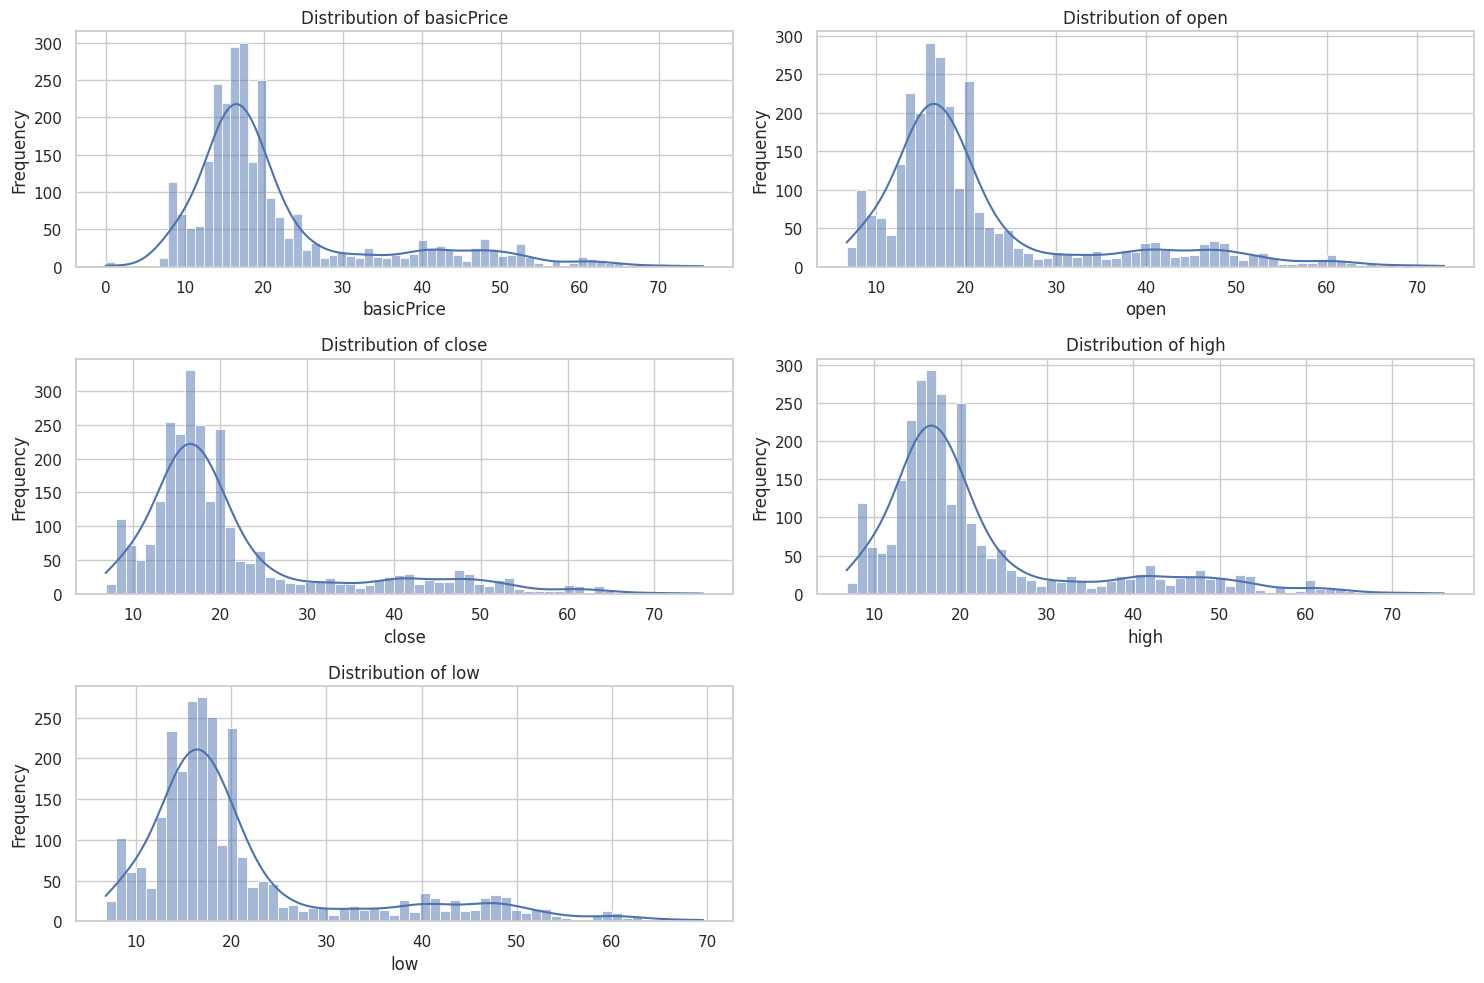

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plotting distributions of numerical columns
for i, column in enumerate(['basicPrice', 'open','close', 'high', 'low']):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

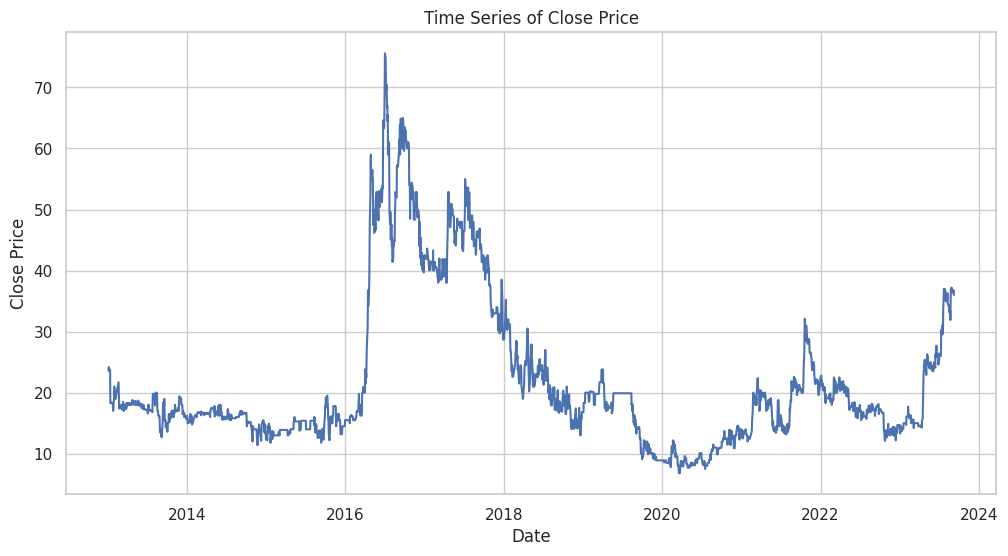

In [ ]:
# Converting 'date' from string to datetime for plotting
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Plotting time series for 'close' price
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='close', data=data)
plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

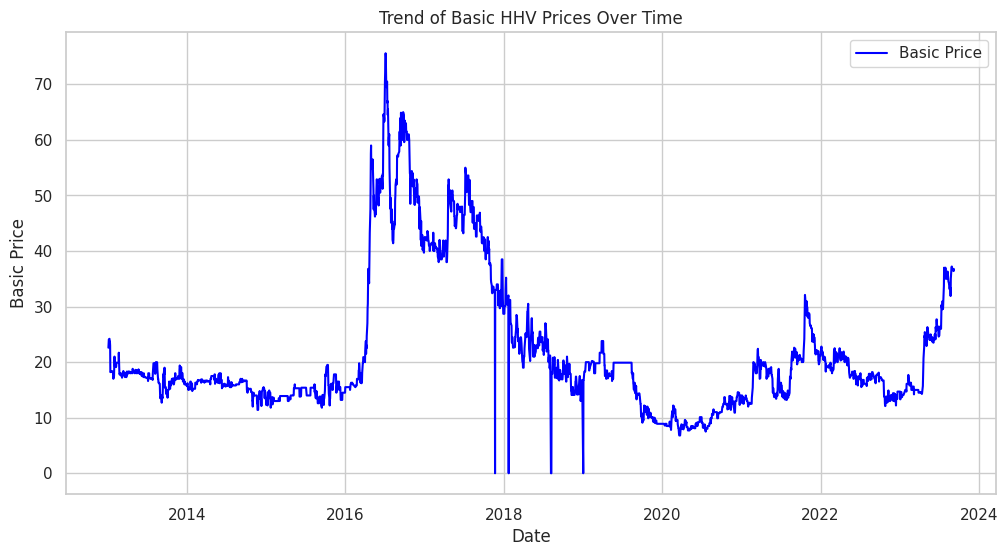

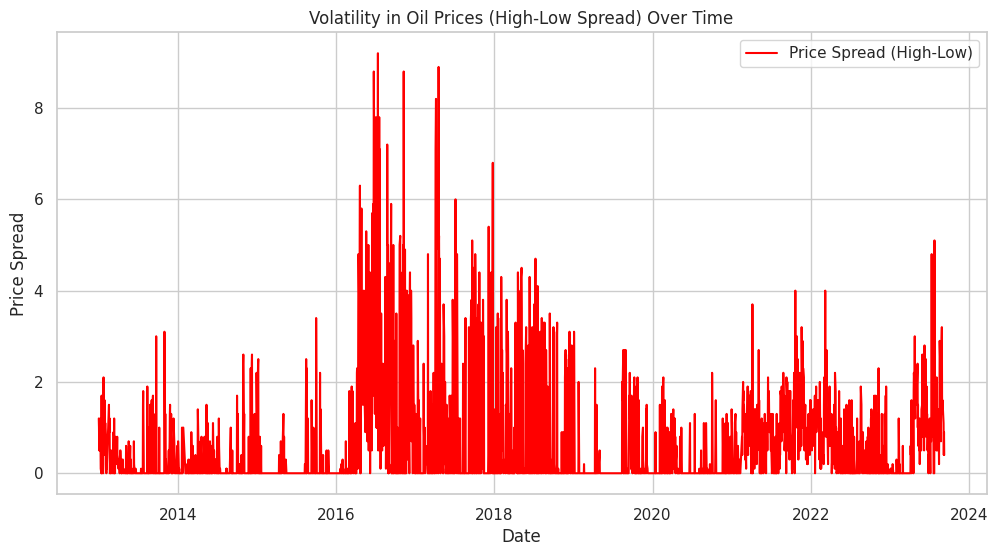

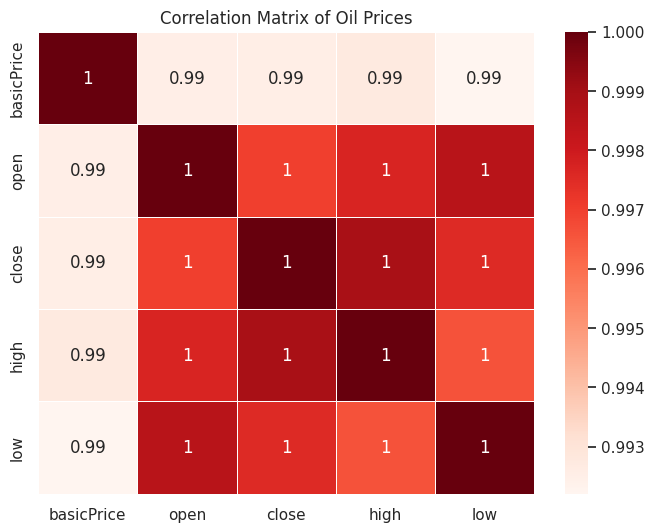

In [ ]:
sns.set(style="whitegrid")

# Trend analysis: Plotting the basic price over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['basicPrice'], label='Basic Price', color='blue')
plt.title('Trend of Basic HHV Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Basic Price')
plt.legend()
plt.show()

# Volatility analysis: High-Low Price Spread
data['price_spread'] = data['high'] - data['low']
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price_spread'], label='Price Spread (High-Low)', color='red')
plt.title('Volatility in Oil Prices (High-Low Spread) Over Time')
plt.xlabel('Date')
plt.ylabel('Price Spread')
plt.legend()
plt.show()

# Correlation
correlation_matrix = data[['basicPrice', 'open', 'close', 'high', 'low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Correlation Matrix of Oil Prices')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Applying the test on the 'basicPrice' column
adf_test_result = test_stationarity(data['basicPrice'])
adf_test_result

Results of Dickey-Fuller Test:


Test Statistic                   -2.251326
p-value                           0.188147
#Lags Used                        3.000000
Number of Observations Used    2737.000000
Critical Value (1%)              -3.432741
Critical Value (5%)              -2.862597
Critical Value (10%)             -2.567332
dtype: float64

In [ ]:
adf_test_result1 = test_stationarity(np.diff(data['basicPrice']))
adf_test_result1

Results of Dickey-Fuller Test:


Test Statistic                -1.336280e+01
p-value                        5.386186e-25
#Lags Used                     2.200000e+01
Number of Observations Used    2.717000e+03
Critical Value (1%)           -3.432759e+00
Critical Value (5%)           -2.862604e+00
Critical Value (10%)          -2.567337e+00
dtype: float64

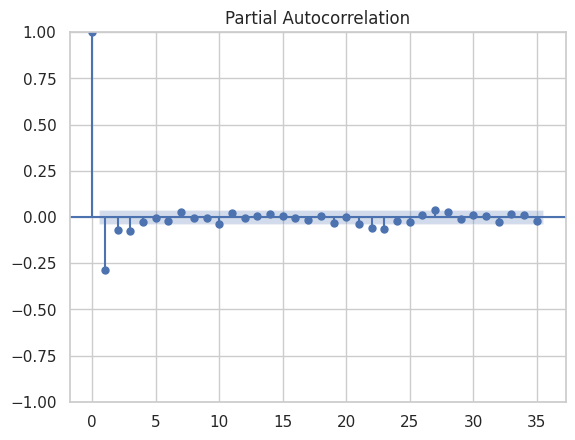

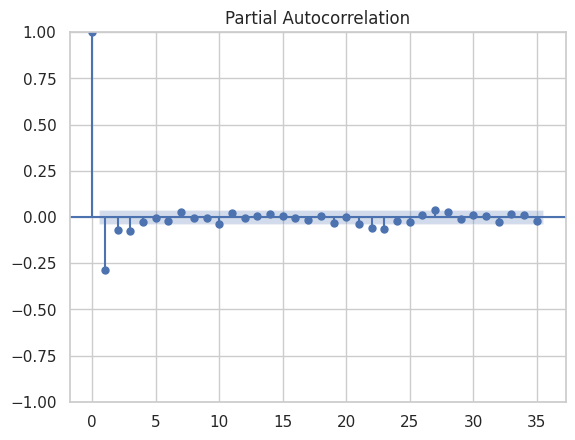

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.diff(data['basicPrice']))

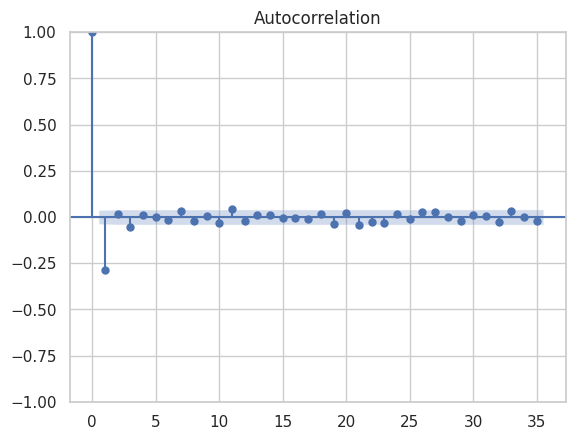

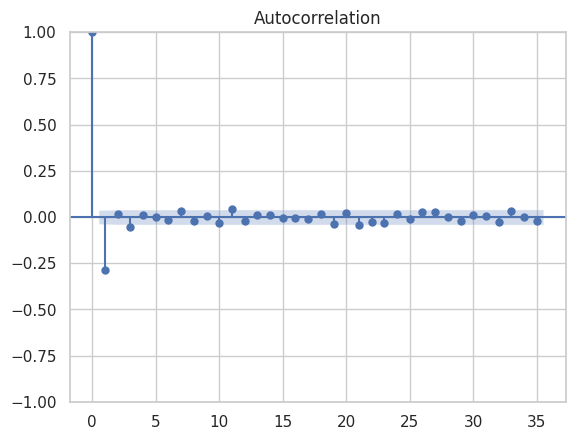

In [ ]:
plot_acf(np.diff(data['basicPrice']))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import itertools
import warnings

# Function to find the best ARIMA parameters
def find_best_arima(series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print('ARIMA({}, {}, {}) AIC={}'.format(p, d, q, aic))
        except:
            continue
    return best_cfg

# Define the p, d, q ranges to test
p_range = range(0, 4)
d_range = range(1, 2)
q_range = range(0, 4)

# Ignoring warning messages to keep the output clean
warnings.filterwarnings("ignore")

# Find the best ARIMA parameters
best_arima_params = find_best_arima(data['basicPrice'], p_range, d_range, q_range)
best_arima_params

ARIMA(0, 1, 0) AIC=10834.067725803563
ARIMA(0, 1, 1) AIC=10578.744602985855
ARIMA(0, 1, 2) AIC=10580.248218248116
ARIMA(0, 1, 3) AIC=10575.164949175345
ARIMA(1, 1, 0) AIC=10601.601493441955
ARIMA(1, 1, 1) AIC=10580.040500530447
ARIMA(1, 1, 2) AIC=10582.144569114347
ARIMA(1, 1, 3) AIC=10576.579942532653
ARIMA(2, 1, 0) AIC=10590.298817068826
ARIMA(2, 1, 1) AIC=10577.362881989804
ARIMA(2, 1, 2) AIC=10577.228054679988
ARIMA(2, 1, 3) AIC=10578.48095180968
ARIMA(3, 1, 0) AIC=10576.904532946062
ARIMA(3, 1, 1) AIC=10576.634445338668
ARIMA(3, 1, 2) AIC=10578.633535112771
ARIMA(3, 1, 3) AIC=10574.757368227147


(3, 1, 3)

In [ ]:
# Fit the best ARIMA model
model = ARIMA(data['basicPrice'], order=(3, 1, 3))
model_fit = model.fit()

# Forecasting the next year (2023)
forecast_periods = 15 # Assuming daily data for 30 days
forecast = model_fit.forecast(steps=forecast_periods)

# Generating dates for the forecasted period (2023)
last_date = data['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='D')[1:]

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Basic Price': forecast.values})
forecast_df

,Date,Forecasted Basic Price
0,2023-09-09,36.618447
1,2023-09-10,36.553875
2,2023-09-11,36.598404
3,2023-09-12,36.581242
4,2023-09-13,36.574897
5,2023-09-14,36.601218
6,2023-09-15,36.559904
7,2023-09-16,36.610801
8,2023-09-17,36.555751
9,2023-09-18,36.609961


**SLS**

In [ ]:
import pandas as pd
import numpy as np
#data = pd.read_csv("/content/sample.csv")
data_all= pd.read_excel("/content/four.xlsx")
data_all.head()
#stock_df = pd.DataFrame(data)
data = data_all[data_all['code'] == 'SLS']
data.head()

,date,code,basicPrice,open,close,high,low
0,2023-09-08,SLS,204.0,204.1,204.4,205.4,204.0
8,2023-09-07,SLS,206.5,206.5,204.0,206.6,203.1
11,2023-09-06,SLS,205.4,206.0,206.5,209.8,205.4
18,2023-09-05,SLS,206.0,210.0,205.4,212.0,203.5
24,2023-08-31,SLS,218.4,211.2,206.0,212.1,203.0


In [ ]:
# Unique values for 'code' column
unique_codes = data['code'].unique()

# Date range in the dataset
min_date = data['date'].min()
max_date = data['date'].max()

unique_codes, min_date, max_date

# Descriptive Statistics for Numerical Fields
numerical_stats = data.describe()
numerical_stats

,basicPrice,open,close,high,low
count,2740.000000,2740.000000,2740.000000,2740.000000,2740.000000
mean,83.869854,83.906788,84.175584,85.127883,82.760292
std,54.255020,54.179374,54.227994,54.874744,53.414682
min,0.000000,22.000000,22.000000,22.000000,22.000000
25%,37.000000,37.100000,37.300000,37.500000,37.000000
50%,63.600000,63.350000,63.800000,64.500000,62.500000
75%,133.025000,133.000000,133.600000,134.900000,130.000000
max,218.400000,226.200000,218.400000,226.200000,216.000000


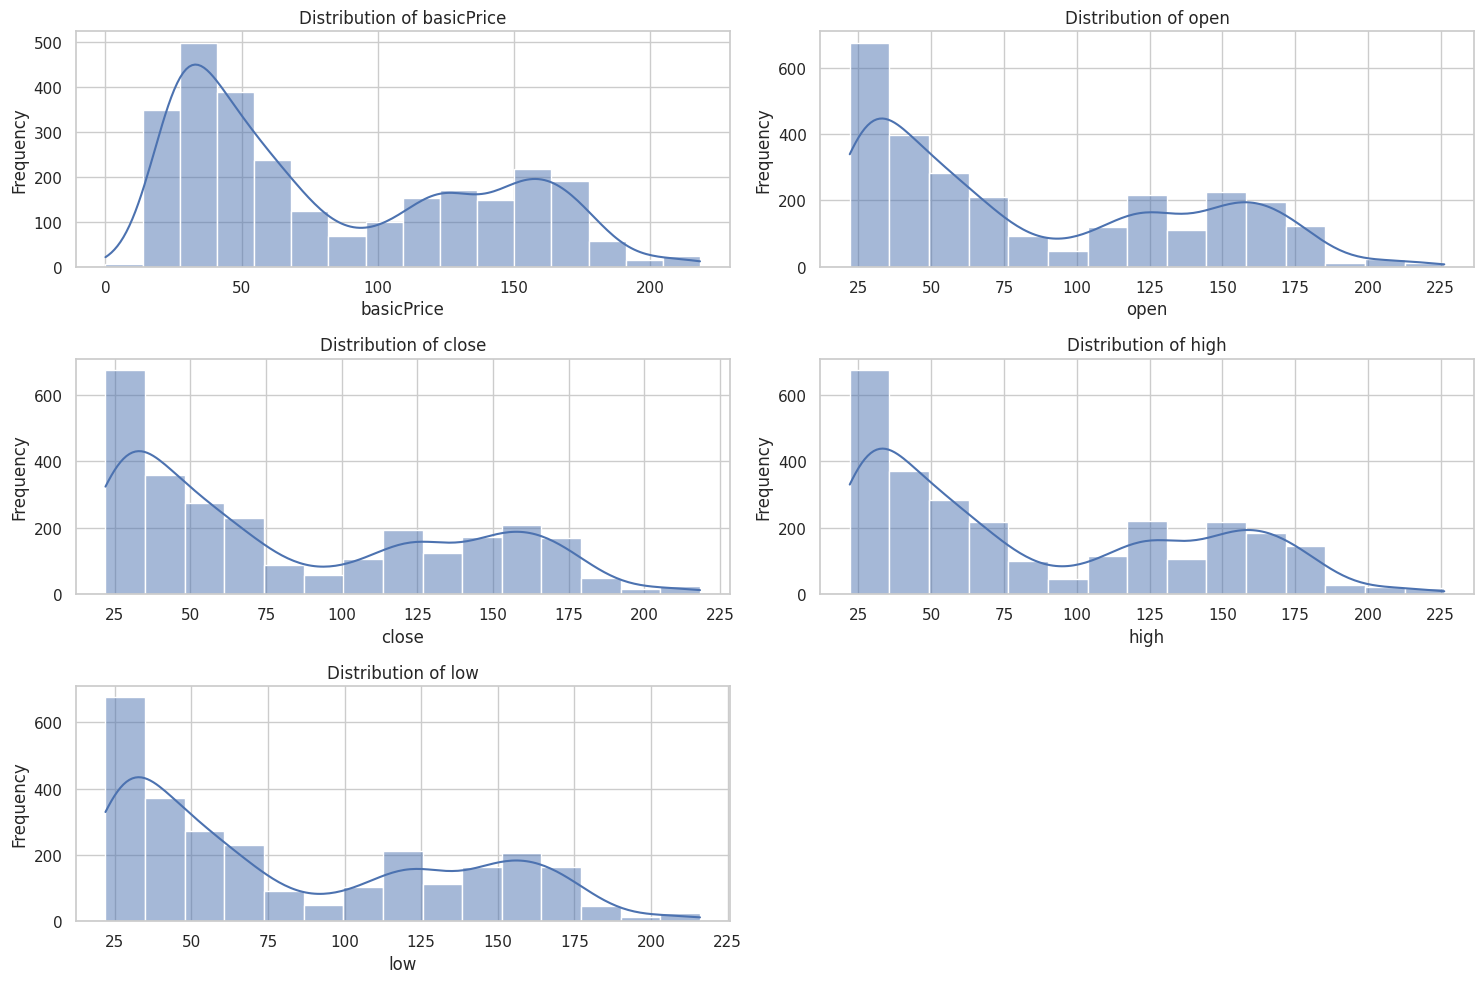

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plotting distributions of numerical columns
for i, column in enumerate(['basicPrice', 'open','close', 'high', 'low']):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-5-6be51df4c0e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


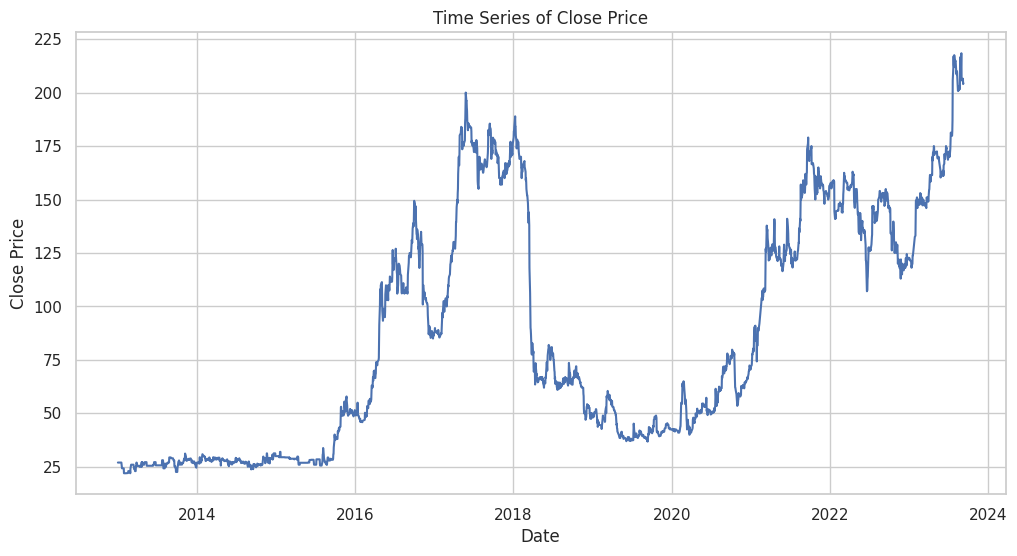

In [ ]:
# Converting 'date' from string to datetime for plotting
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Plotting time series for 'close' price
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='close', data=data)
plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

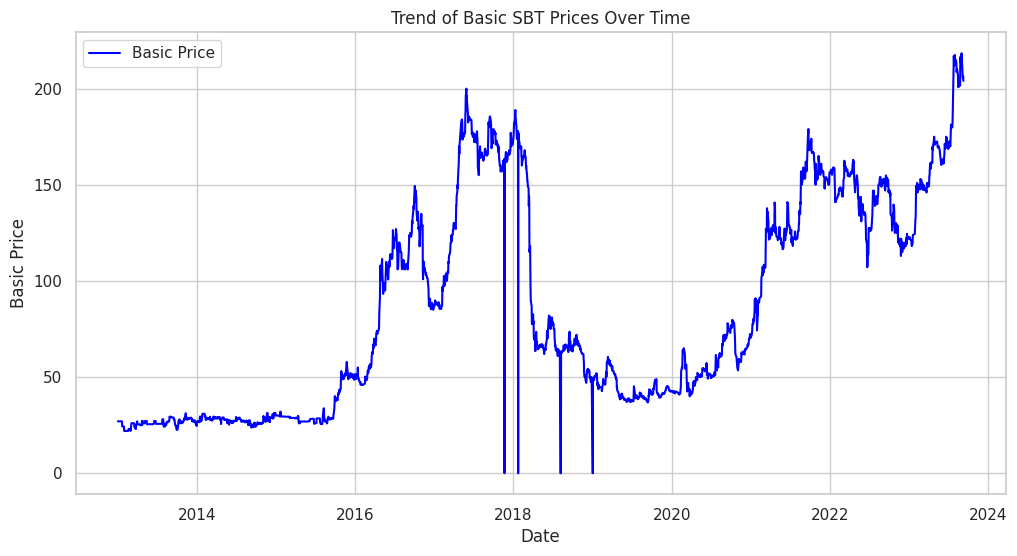

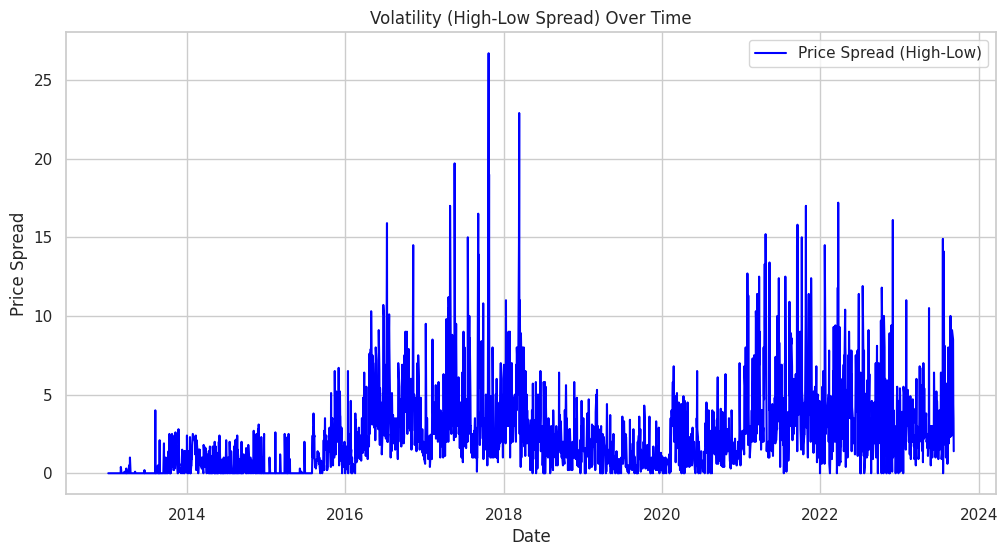

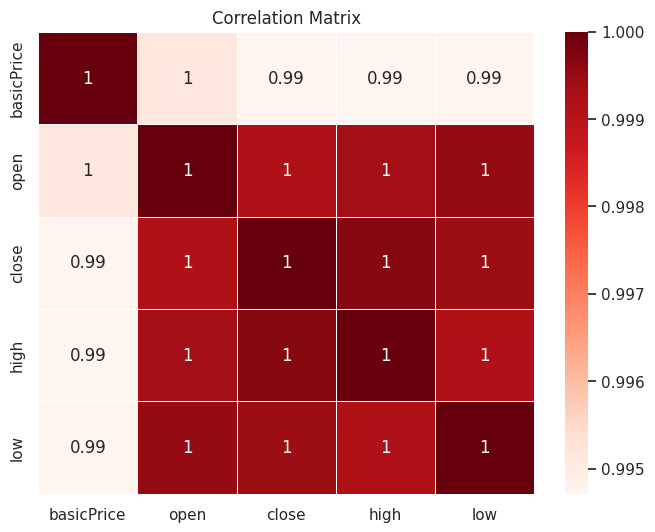

In [ ]:
sns.set(style="whitegrid")

# Trend analysis: Plotting the basic price over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['basicPrice'], label='Basic Price', color='blue')
plt.title('Trend of Basic SBT Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Basic Price')
plt.legend()
plt.show()

# Volatility analysis: High-Low Price Spread
data['price_spread'] = data['high'] - data['low']
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price_spread'], label='Price Spread (High-Low)', color='blue')
plt.title('Volatility (High-Low Spread) Over Time')
plt.xlabel('Date')
plt.ylabel('Price Spread')
plt.legend()
plt.show()

# Correlation
correlation_matrix = data[['basicPrice', 'open', 'close', 'high', 'low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Applying the test on the 'close' column
adf_test_result = test_stationarity(data['close'])
adf_test_result

Results of Dickey-Fuller Test:


Test Statistic                   -0.690457
p-value                           0.849206
#Lags Used                        4.000000
Number of Observations Used    2735.000000
Critical Value (1%)              -3.432743
Critical Value (5%)              -2.862597
Critical Value (10%)             -2.567333
dtype: float64

Since data is stationary, we need to perform first-order differencing

In [ ]:
adf_test_result1 = test_stationarity(np.diff(data['close']))
adf_test_result1

Results of Dickey-Fuller Test:


Test Statistic                  -46.627046
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2738.000000
Critical Value (1%)              -3.432741
Critical Value (5%)              -2.862596
Critical Value (10%)             -2.567332
dtype: float64

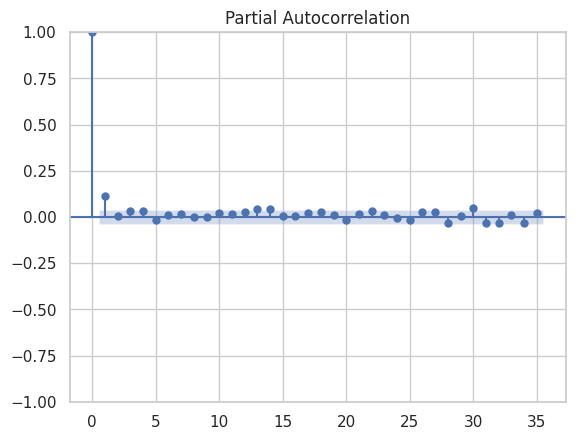

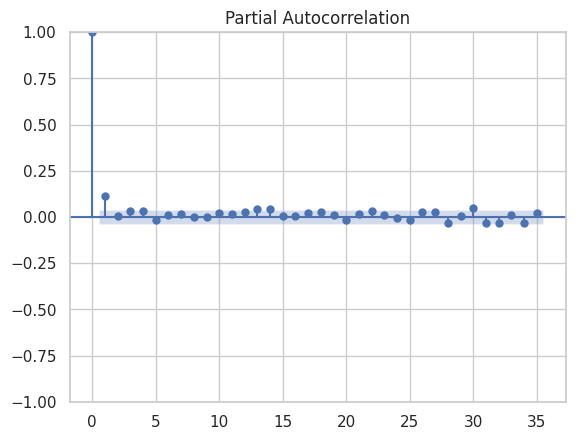

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.diff(data['close']))

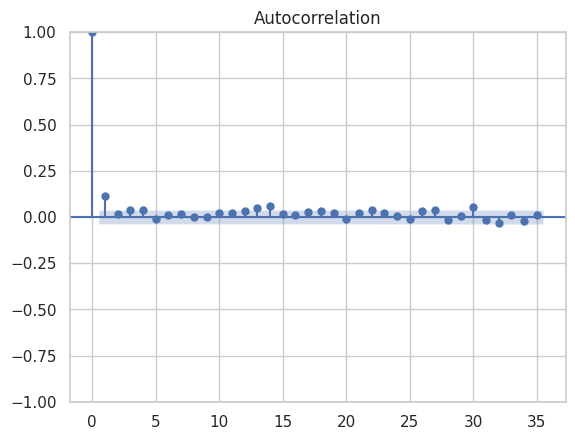

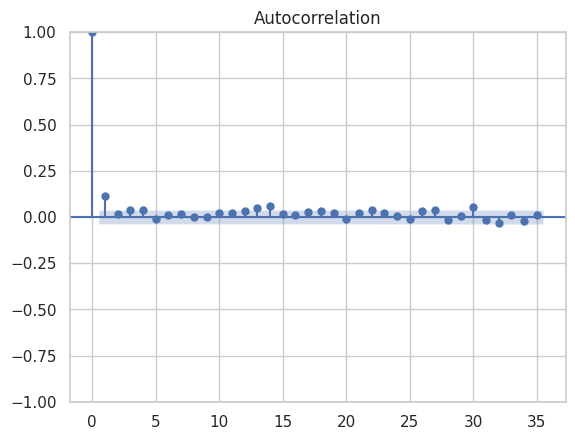

In [ ]:
plot_acf(np.diff(data['close']))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import itertools
import warnings

# Function to find the best ARIMA parameters
def find_best_arima(series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print('ARIMA({}, {}, {}) AIC={}'.format(p, d, q, aic))
        except:
            continue
    return best_cfg

# Define the p, d, q ranges to test
p_range = range(0, 3)
d_range = range(1, 2)
q_range = range(0, 3)

# Ignoring warning messages to keep the output clean
warnings.filterwarnings("ignore")

# Find the best ARIMA parameters
best_arima_params = find_best_arima(data['close'], p_range, d_range, q_range)
best_arima_params

ARIMA(0, 1, 0) AIC=12499.774609285258
ARIMA(0, 1, 1) AIC=12465.880246600133
ARIMA(0, 1, 2) AIC=12467.510791112625
ARIMA(1, 1, 0) AIC=12465.260096273607
ARIMA(1, 1, 1) AIC=12467.010194877952
ARIMA(1, 1, 2) AIC=12458.558618832605
ARIMA(2, 1, 0) AIC=12467.17485011938
ARIMA(2, 1, 1) AIC=12459.197805358566
ARIMA(2, 1, 2) AIC=12460.148877549556


(1, 1, 2)

In [ ]:
# Fit the best ARIMA model
model = ARIMA(data['close'], order=(0, 1, 1))
model_fit = model.fit()

# Forecasting the next year (2023)
forecast_periods = 15 # Assuming daily data for 30 days
forecast = model_fit.forecast(steps=forecast_periods)

# Generating dates for the forecasted period (2023)
last_date = data['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='D')[1:]

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Basic Price': forecast.values})
forecast_df

,Date,Forecasted Basic Price
0,2023-09-09,204.479044
1,2023-09-10,204.479044
2,2023-09-11,204.479044
3,2023-09-12,204.479044
4,2023-09-13,204.479044
5,2023-09-14,204.479044
6,2023-09-15,204.479044
7,2023-09-16,204.479044
8,2023-09-17,204.479044
9,2023-09-18,204.479044


**LSS**

In [ ]:
import pandas as pd
import numpy as np
#data = pd.read_csv("/content/sample.csv")
data_all= pd.read_excel("/content/four.xlsx")
data_all.head()
#stock_df = pd.DataFrame(data)
data = data_all[data_all['code'] == 'LSS']
data.head()

,date,code,basicPrice,open,close,high,low
1,2023-09-08,LSS,13.55,13.65,13.75,14.15,13.60
7,2023-09-07,LSS,13.70,13.75,13.55,13.75,13.40
12,2023-09-06,LSS,13.40,13.70,13.70,13.90,13.55
15,2023-09-05,LSS,13.35,13.65,13.40,13.70,13.35
20,2023-08-31,LSS,13.35,13.40,13.35,13.50,13.10


In [ ]:
# Unique values for 'code' column
unique_codes = data['code'].unique()

# Date range in the dataset
min_date = data['date'].min()
max_date = data['date'].max()

unique_codes, min_date, max_date

# Descriptive Statistics for Numerical Fields
numerical_stats = data.describe()
numerical_stats

,basicPrice,open,close,high,low
count,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000
mean,9.987977,10.015851,10.001896,10.187286,9.831837
std,3.356357,3.347020,3.330504,3.410257,3.278163
min,0.000000,3.770000,3.830000,3.990000,3.770000
25%,7.000000,7.000000,7.000000,7.100000,6.900000
50%,10.200000,10.150000,10.200000,10.300000,10.000000
75%,12.687500,12.700000,12.700000,12.950000,12.500000
max,19.600000,19.700000,19.600000,20.200000,19.400000


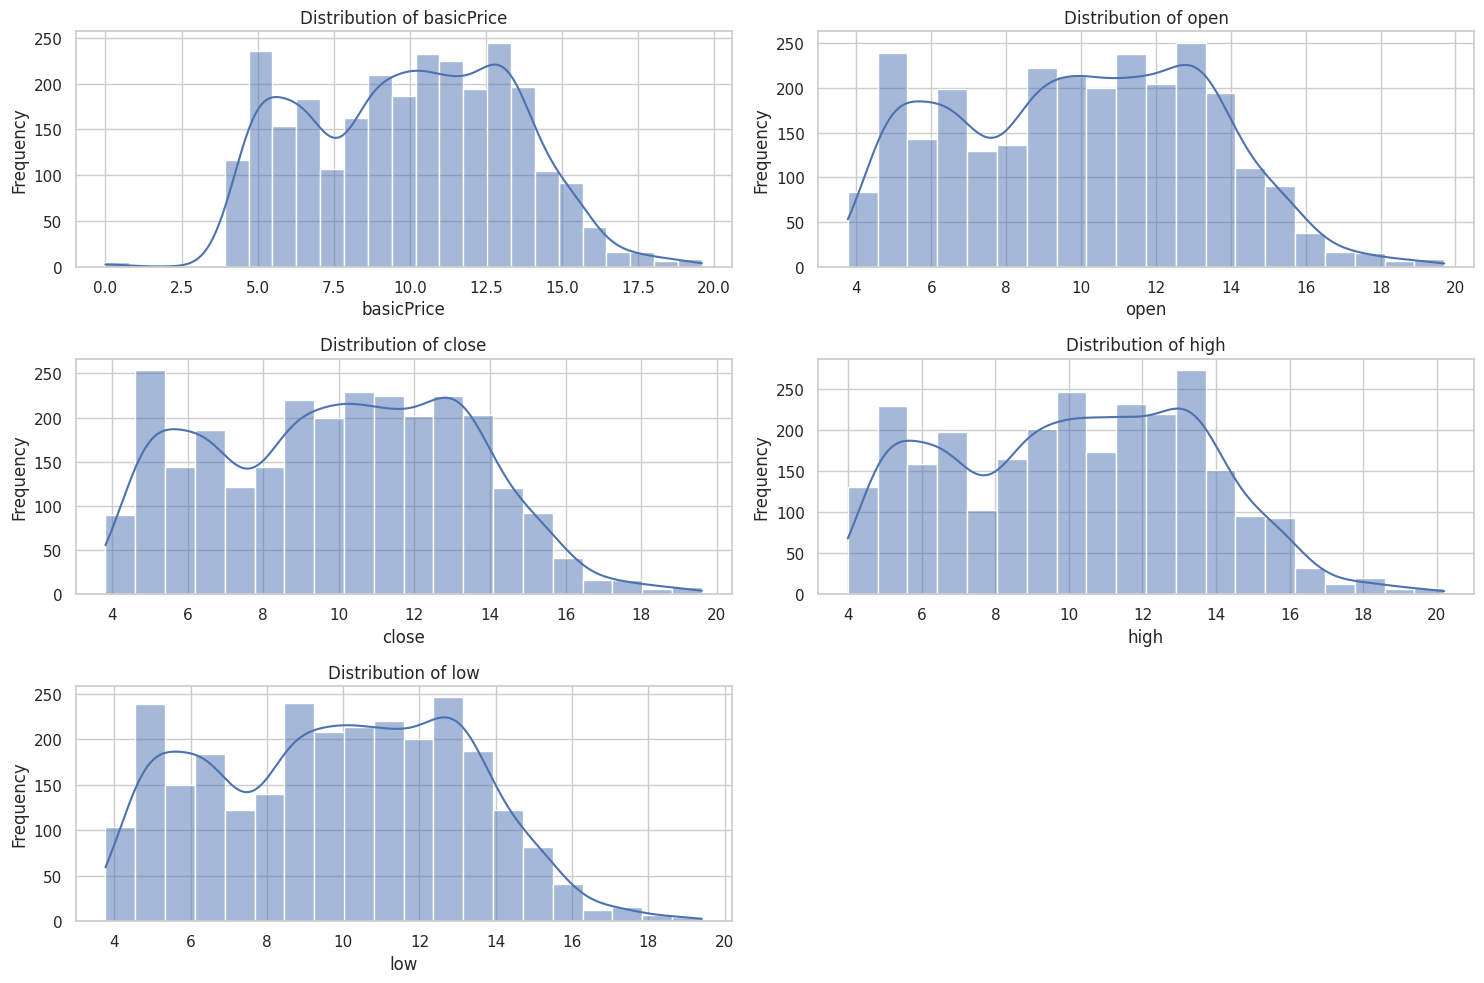

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plotting distributions of numerical columns
for i, column in enumerate(['basicPrice', 'open','close', 'high', 'low']):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

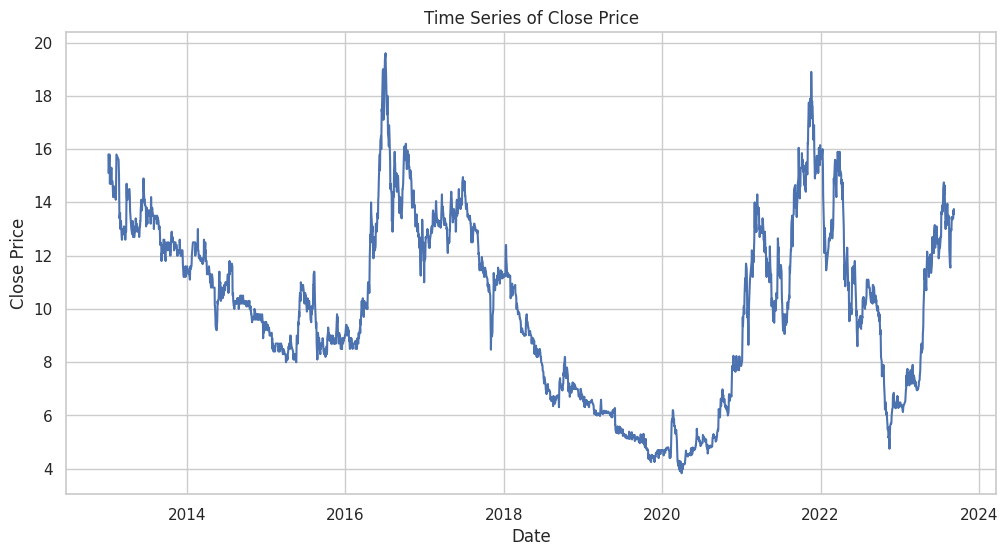

In [ ]:
# Converting 'date' from string to datetime for plotting
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Plotting time series for 'close' price
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='close', data=data)
plt.title('Time Series of Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

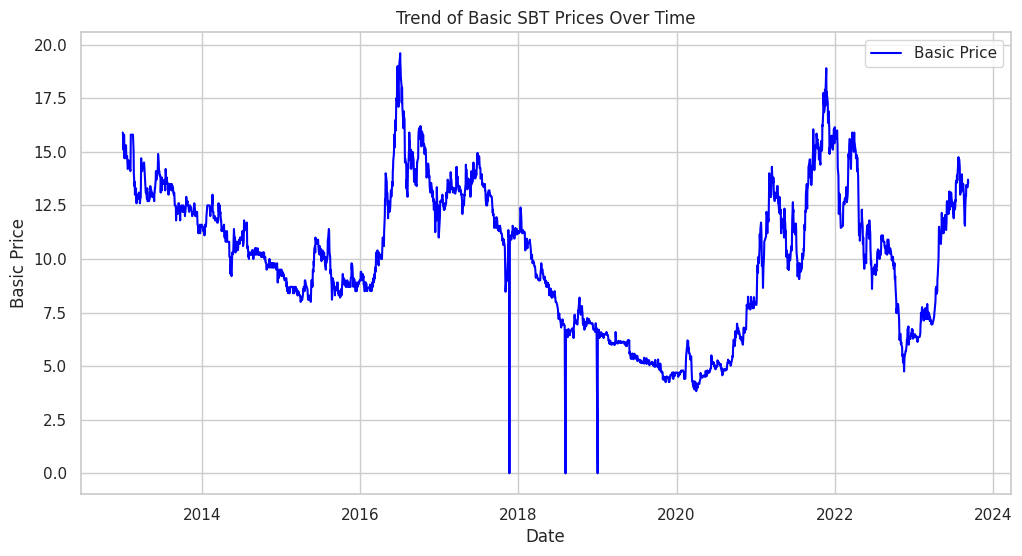

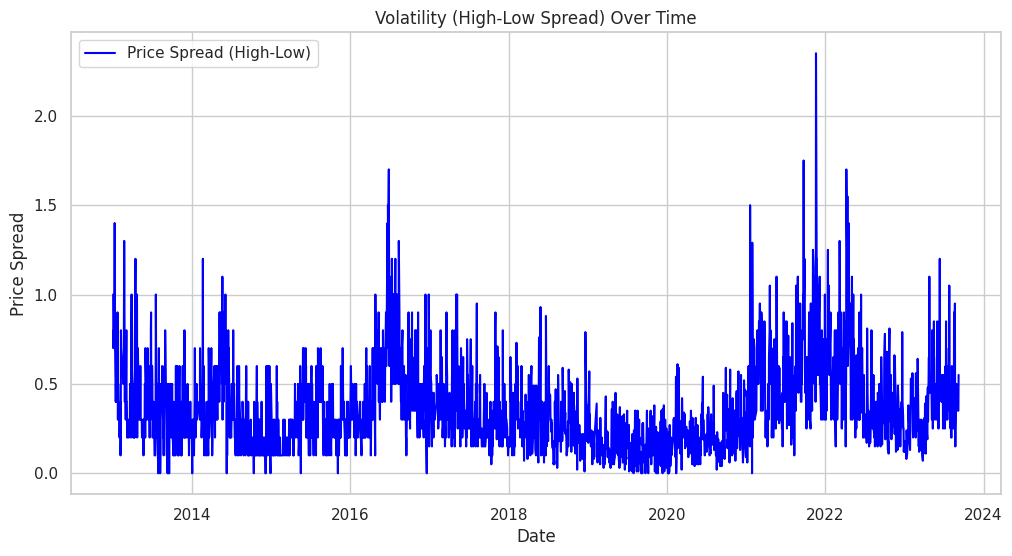

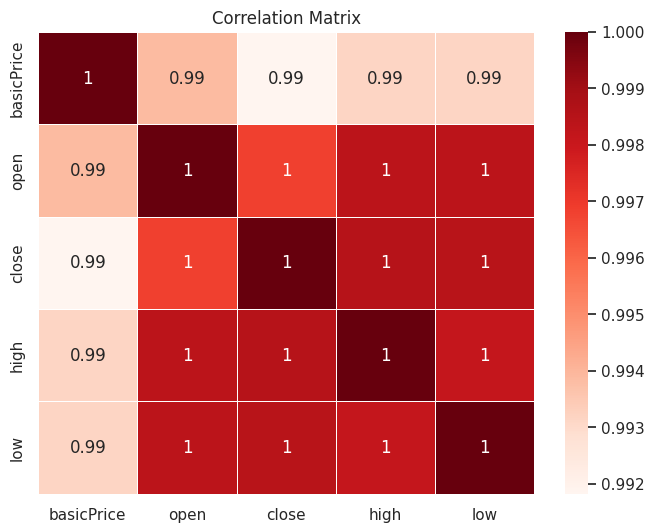

In [ ]:
sns.set(style="whitegrid")

# Trend analysis: Plotting the basic price over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['basicPrice'], label='Basic Price', color='blue')
plt.title('Trend of Basic SBT Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Basic Price')
plt.legend()
plt.show()

# Volatility analysis: High-Low Price Spread
data['price_spread'] = data['high'] - data['low']
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price_spread'], label='Price Spread (High-Low)', color='blue')
plt.title('Volatility (High-Low Spread) Over Time')
plt.xlabel('Date')
plt.ylabel('Price Spread')
plt.legend()
plt.show()

# Correlation
correlation_matrix = data[['basicPrice', 'open', 'close', 'high', 'low']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Applying the test on the 'close' column
adf_test_result = test_stationarity(data['close'])
adf_test_result

Results of Dickey-Fuller Test:


Test Statistic                   -2.464296
p-value                           0.124405
#Lags Used                        4.000000
Number of Observations Used    2733.000000
Critical Value (1%)              -3.432745
Critical Value (5%)              -2.862598
Critical Value (10%)             -2.567333
dtype: float64

Since data is stationary, we need to perform first-order differencing

In [ ]:
adf_test_result1 = test_stationarity(np.diff(data['close']))
adf_test_result1

Results of Dickey-Fuller Test:


Test Statistic                  -38.296160
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    2735.000000
Critical Value (1%)              -3.432743
Critical Value (5%)              -2.862597
Critical Value (10%)             -2.567333
dtype: float64

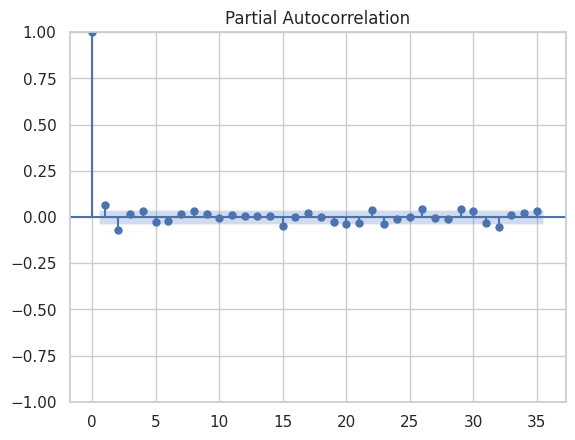

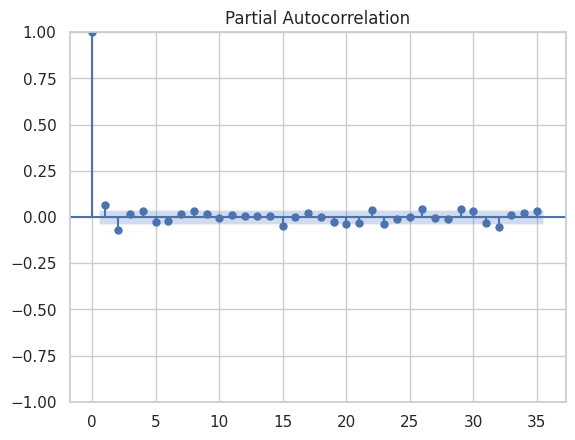

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.diff(data['close']))

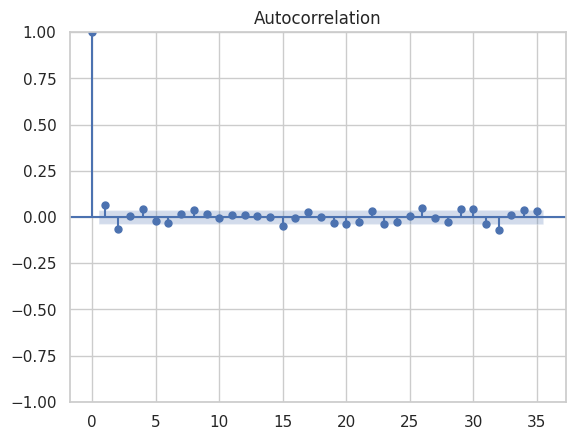

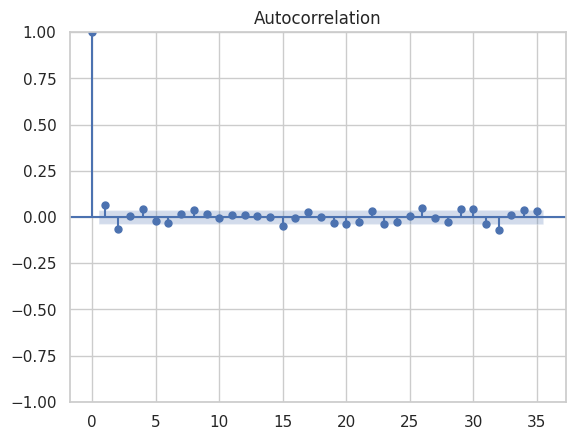

In [ ]:
plot_acf(np.diff(data['close']))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import itertools
import warnings

# Function to find the best ARIMA parameters
def find_best_arima(series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print('ARIMA({}, {}, {}) AIC={}'.format(p, d, q, aic))
        except:
            continue
    return best_cfg

# Define the p, d, q ranges to test
p_range = range(0, 3)
d_range = range(1, 2)
q_range = range(0, 3)

# Ignoring warning messages to keep the output clean
warnings.filterwarnings("ignore")

# Find the best ARIMA parameters
best_arima_params = find_best_arima(data['close'], p_range, d_range, q_range)
best_arima_params

ARIMA(0, 1, 0) AIC=825.2504597382604
ARIMA(0, 1, 1) AIC=813.6258982512081
ARIMA(0, 1, 2) AIC=804.9830913082637
ARIMA(1, 1, 0) AIC=815.4582657078108
ARIMA(1, 1, 1) AIC=809.2045566461808
ARIMA(1, 1, 2) AIC=806.9775507403341
ARIMA(2, 1, 0) AIC=804.4186407174211
ARIMA(2, 1, 1) AIC=806.126881348705
ARIMA(2, 1, 2) AIC=802.1011414463874


(2, 1, 2)

In [ ]:
# Fit the best ARIMA model
model = ARIMA(data['close'], order=(0, 1, 1))
model_fit = model.fit()

# Forecasting the next year (2023)
forecast_periods = 15 # Assuming daily data for 30 days
forecast = model_fit.forecast(steps=forecast_periods)

# Generating dates for the forecasted period (2023)
last_date = data['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='D')[1:]

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Basic Price': forecast.values})
forecast_df

,Date,Forecasted Basic Price
0,2023-09-09,13.766151
1,2023-09-10,13.766151
2,2023-09-11,13.766151
3,2023-09-12,13.766151
4,2023-09-13,13.766151
5,2023-09-14,13.766151
6,2023-09-15,13.766151
7,2023-09-16,13.766151
8,2023-09-17,13.766151
9,2023-09-18,13.766151
